In [1]:
# RUN THIS CELL BEFORE CONTINUING
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Download data
hdi_composite_data_raw <- read_csv("https://raw.githubusercontent.com/phoenixjin8/dsci100-group-project/main/data/hdr_composite_index.csv", show_col_types = FALSE)
poverty_rate_data_raw <- read_csv("https://raw.githubusercontent.com/phoenixjin8/dsci100-group-project/main/data/poverty_rate.csv", skip = 4, show_col_types = FALSE)

# Tidy poverty rate data
poverty_rate_data <- poverty_rate_data_raw |>
    select(-country_name, -indicator_name, -indicator_code, -development) |>
    pivot_longer(c(-country_code), names_to = "year", values_to = "poverty_rate") |>
    filter(!is.na(poverty_rate))

# Tidy HDI data
# Eliminate irrelevant columns
hdi_composite_data_raw <- hdi_composite_data_raw |>
    select(-country, -hdicode, -region, -hdi_rank_2021)
# We will write to a new dataframe rather than edit the existing one since the raw data is horrific to work with
# Extract CO2 emissions data and country codes
hdi_composite_data <- hdi_composite_data_raw |>
    select(iso3, co2_prod_1990:co2_prod_2021) |>
    # Remove all information from column name except the year (change each column name to the last 4 characters of itself, ignore "iso3")
    rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
    pivot_longer(-iso3, names_to = "year", values_to = "co2_per_capita")
# Extract mean years of schooling data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_raw |>
                             select(iso3, mys_1990:mys_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "mean_schooling")))
# Extract GNI per capita data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_raw |>
                             select(iso3, gnipc_1990:gnipc_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "gni_per_capita")))
# Extract life expectancy data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_raw |>
                             select(iso3, le_1990:le_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "life_expectancy")))

# Merge HDI data with poverty rate data and convert year to a number
tidy_data <- merge(poverty_rate_data, hdi_composite_data, by.x = c("country_code", "year"), by.y = c("iso3", "year"), all = TRUE) |>
    mutate(year = as.numeric(year))

# Add development rating
tidy_data <- left_join(tidy_data, select(poverty_rate_data_raw, country_code, development), by = "country_code") |>
    mutate(development = as.factor(development))

# Reorder the columns to make sense
tidy_data <- tidy_data[,c("country_code", "development", "year", "life_expectancy", "gni_per_capita", "poverty_rate", "mean_schooling", "co2_per_capita")] |>
    
# Remove the ~3 data points that are WAY out the bottom, highly likely to be measurement errors and messing up the graph scaling
    filter(life_expectancy > 25) |>

# Remove every row with no life expectancy value, since everything is based on those values
    filter(!is.na(life_expectancy)) |>

# Remove the one or two countries that aren't classified into a development category
    filter(!is.na(development))

# Reorder the development category so that legends are in a reasonable order
tidy_data$development <- factor(tidy_data$development, levels = c("Very High", "High", "Medium", "Low"))

tidy_data

country_code,development,year,life_expectancy,gni_per_capita,poverty_rate,mean_schooling,co2_per_capita
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Low,1990,45.9672,2684.550,NA,0.9711254,0.20972731
AFG,Low,1991,46.6631,2276.289,NA,1.0193558,0.18252477
AFG,Low,1992,47.5955,2059.868,NA,1.0675862,0.09523286
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ZWE,Medium,2019,61.2925,3674.564,85,8.710909,0.7476101
ZWE,Medium,2020,61.1242,3654.289,NA,8.710909,0.7085618
ZWE,Medium,2021,59.2531,3809.887,NA,8.710909,0.7085618


In [3]:
data_split <- initial_split(tidy_data, prop = 0.75, strata = life_expectancy)
training_data <- training(data_split)
testing_data <- testing(data_split)

In [4]:
# Select the columns that contain data we plan to model
data_cols <- select(training_data, life_expectancy:co2_per_capita)

# Count rows with missing data
missing_data_table <- tibble(
    life_expectancy = numeric(),
    gni_per_capita = numeric(),
    poverty_rate = numeric(),
    mean_schooling = numeric(),
    co2_per_capita = numeric()) |> 
    add_row(as_tibble_row(colSums(is.na(data_cols))))

# Take mean of each column
mean_table <- tibble(
    life_expectancy = numeric(),
    gni_per_capita = numeric(),
    poverty_rate = numeric(),
    mean_schooling = numeric(),
    co2_per_capita = numeric()) |> 
    add_row(as_tibble_row(colMeans(data_cols, na.rm = TRUE)))

missing_data_table
mean_table

life_expectancy,gni_per_capita,poverty_rate,mean_schooling,co2_per_capita
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,34,3252,326,38


life_expectancy,gni_per_capita,poverty_rate,mean_schooling,co2_per_capita
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
68.55889,17002.8,33.89016,7.679869,4.577446


Warning message:
“Removed 34 rows containing missing values (geom_point).”
Warning message:
“Removed 3252 rows containing missing values (geom_point).”


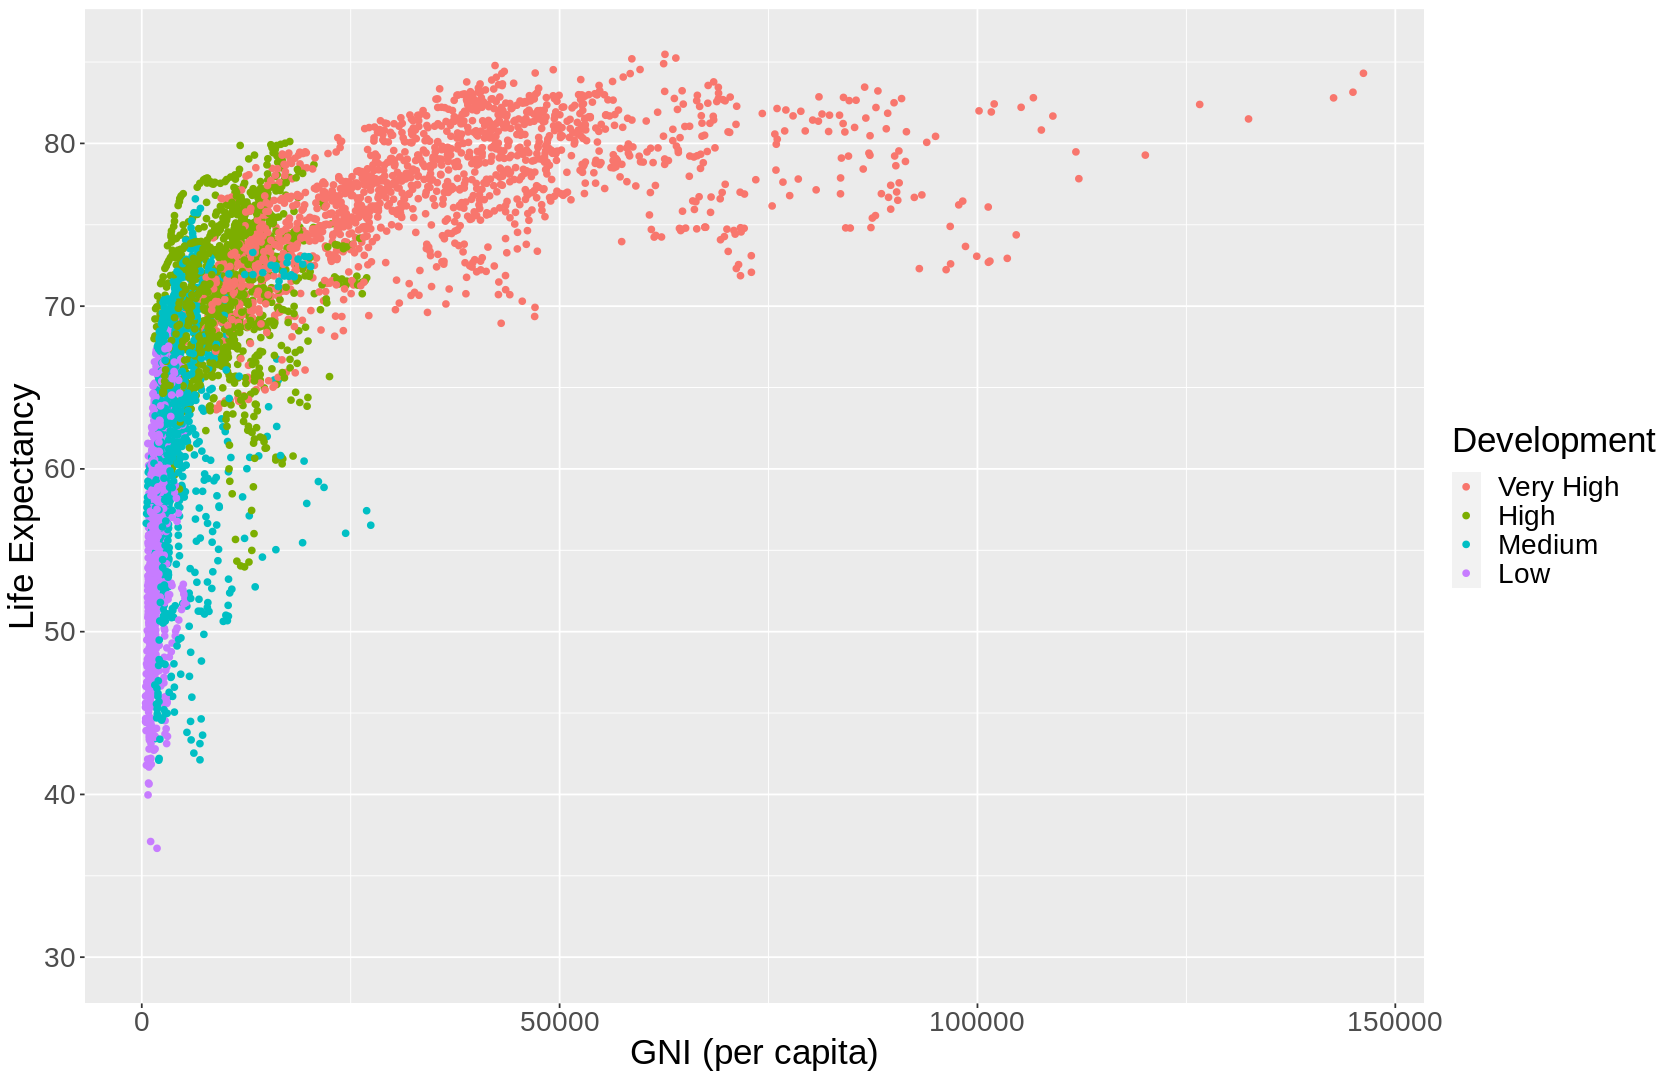

Warning message:
“Removed 326 rows containing missing values (geom_point).”


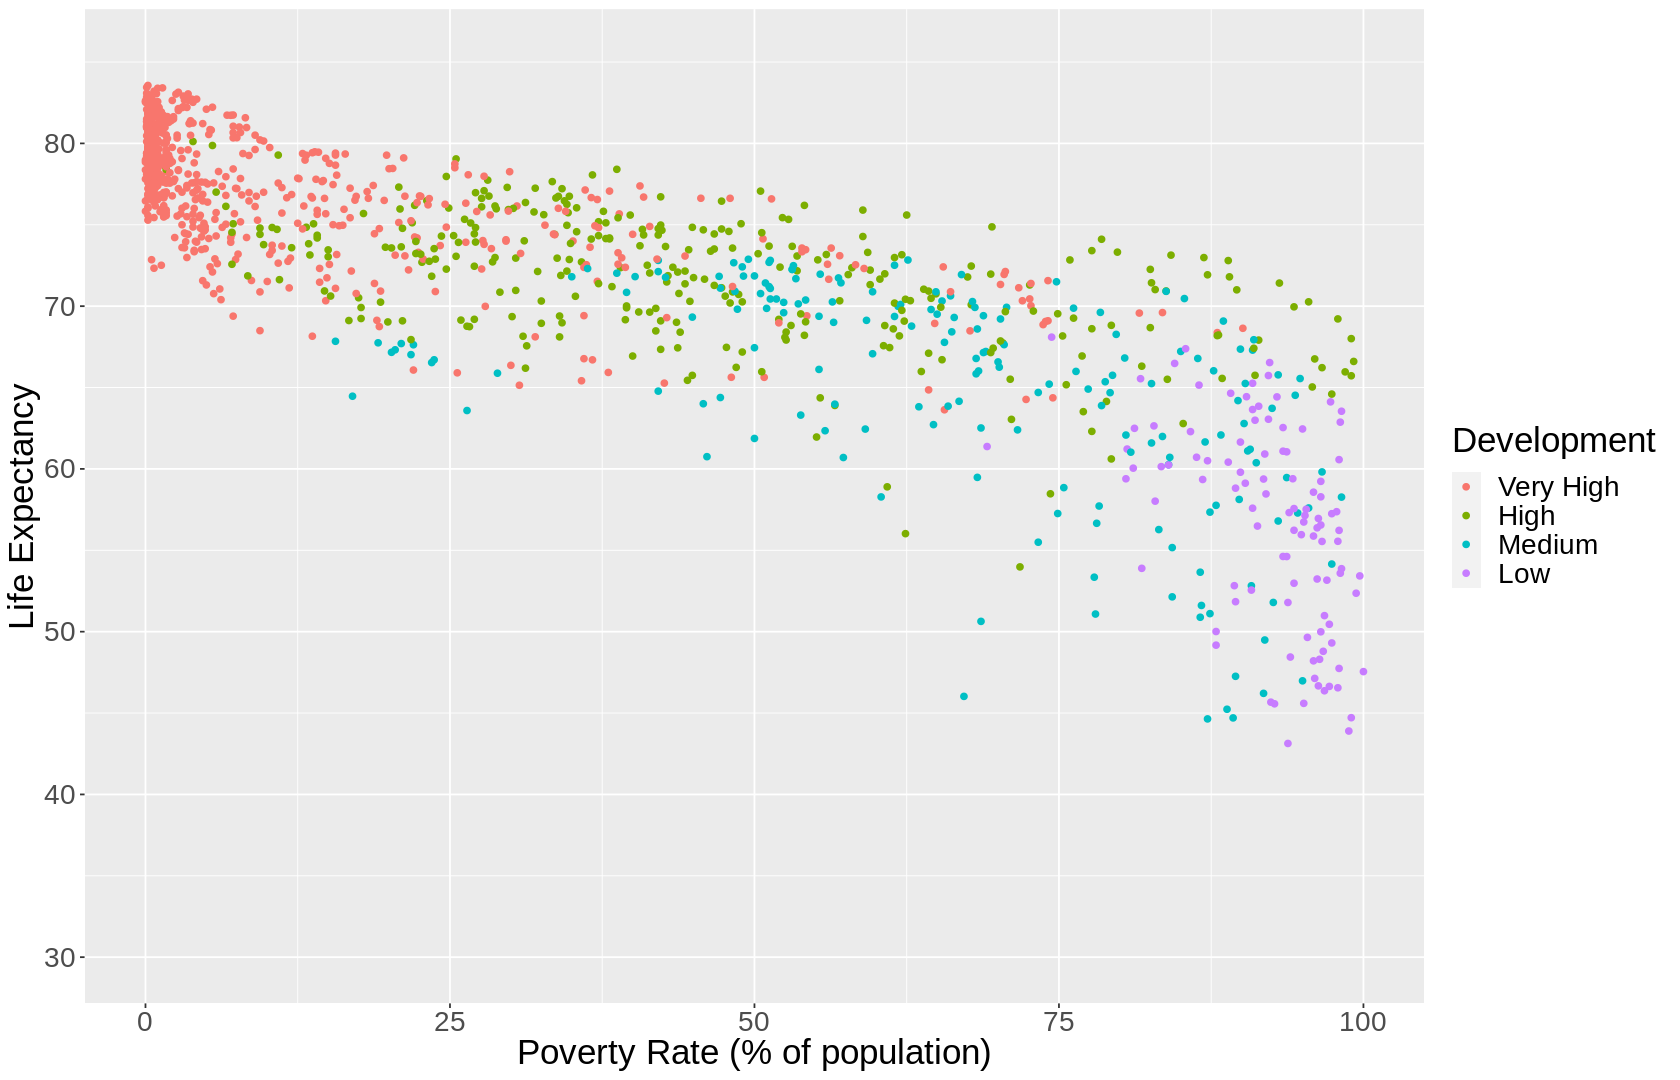

Warning message:
“Removed 38 rows containing missing values (geom_point).”


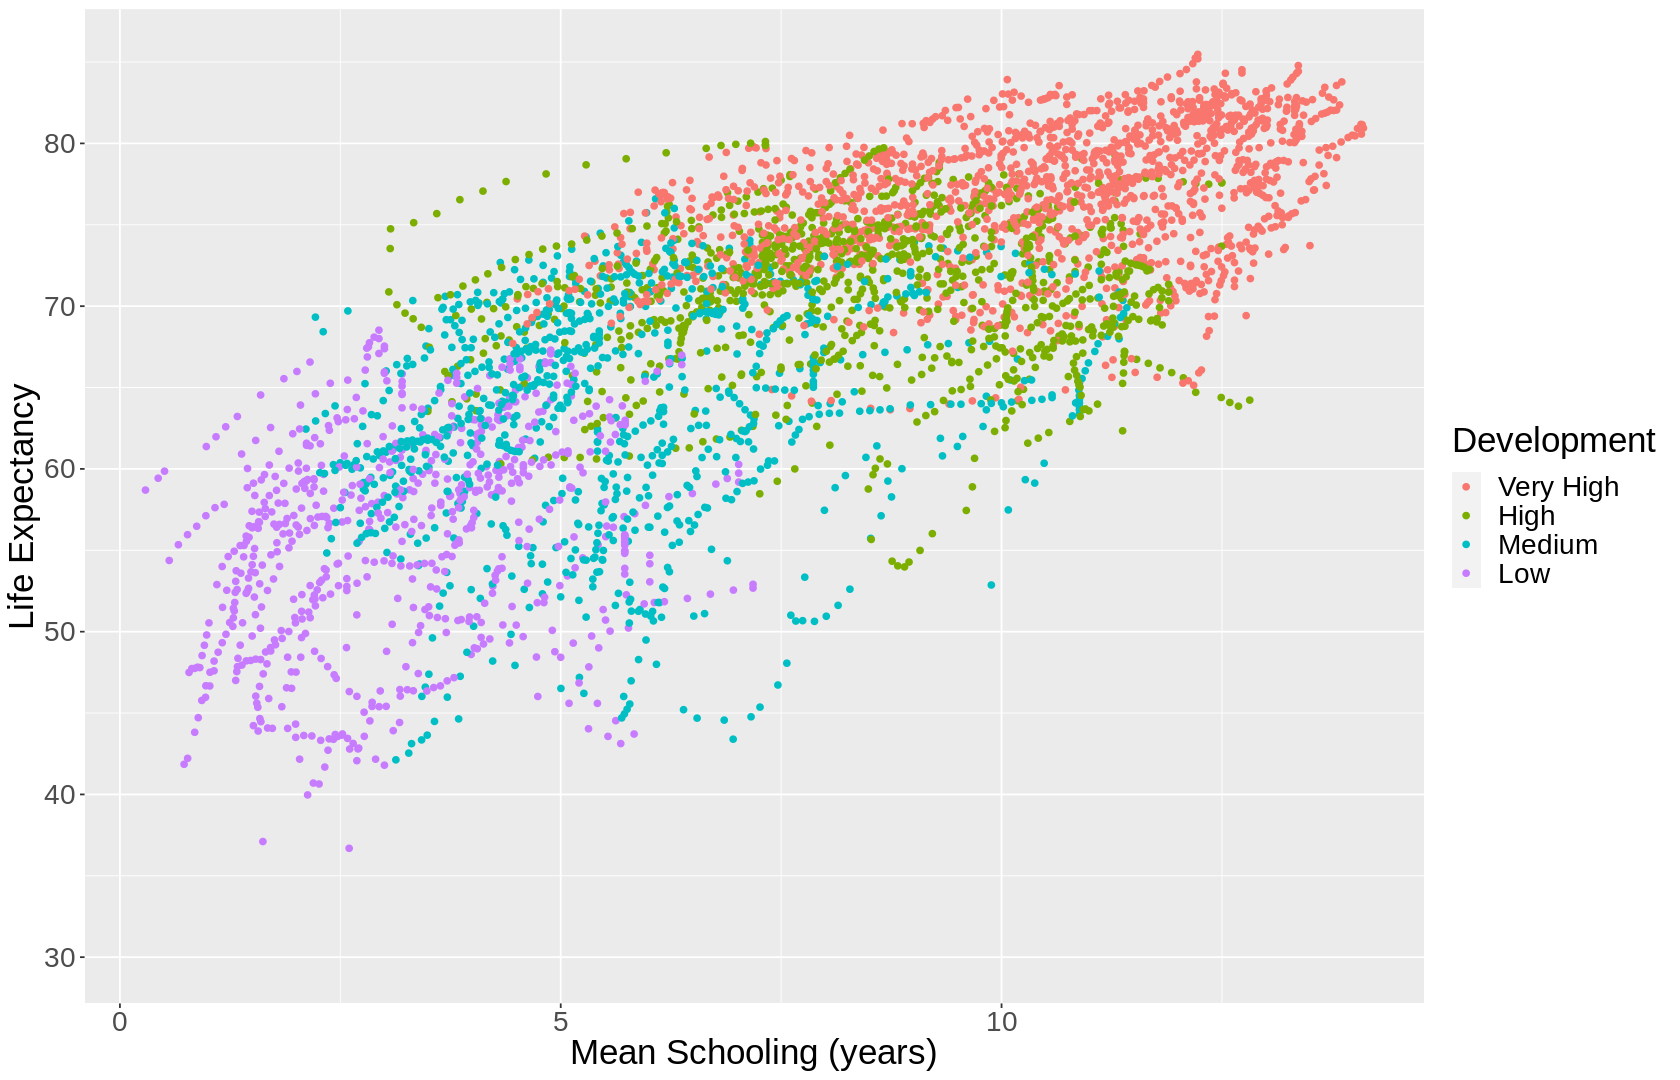

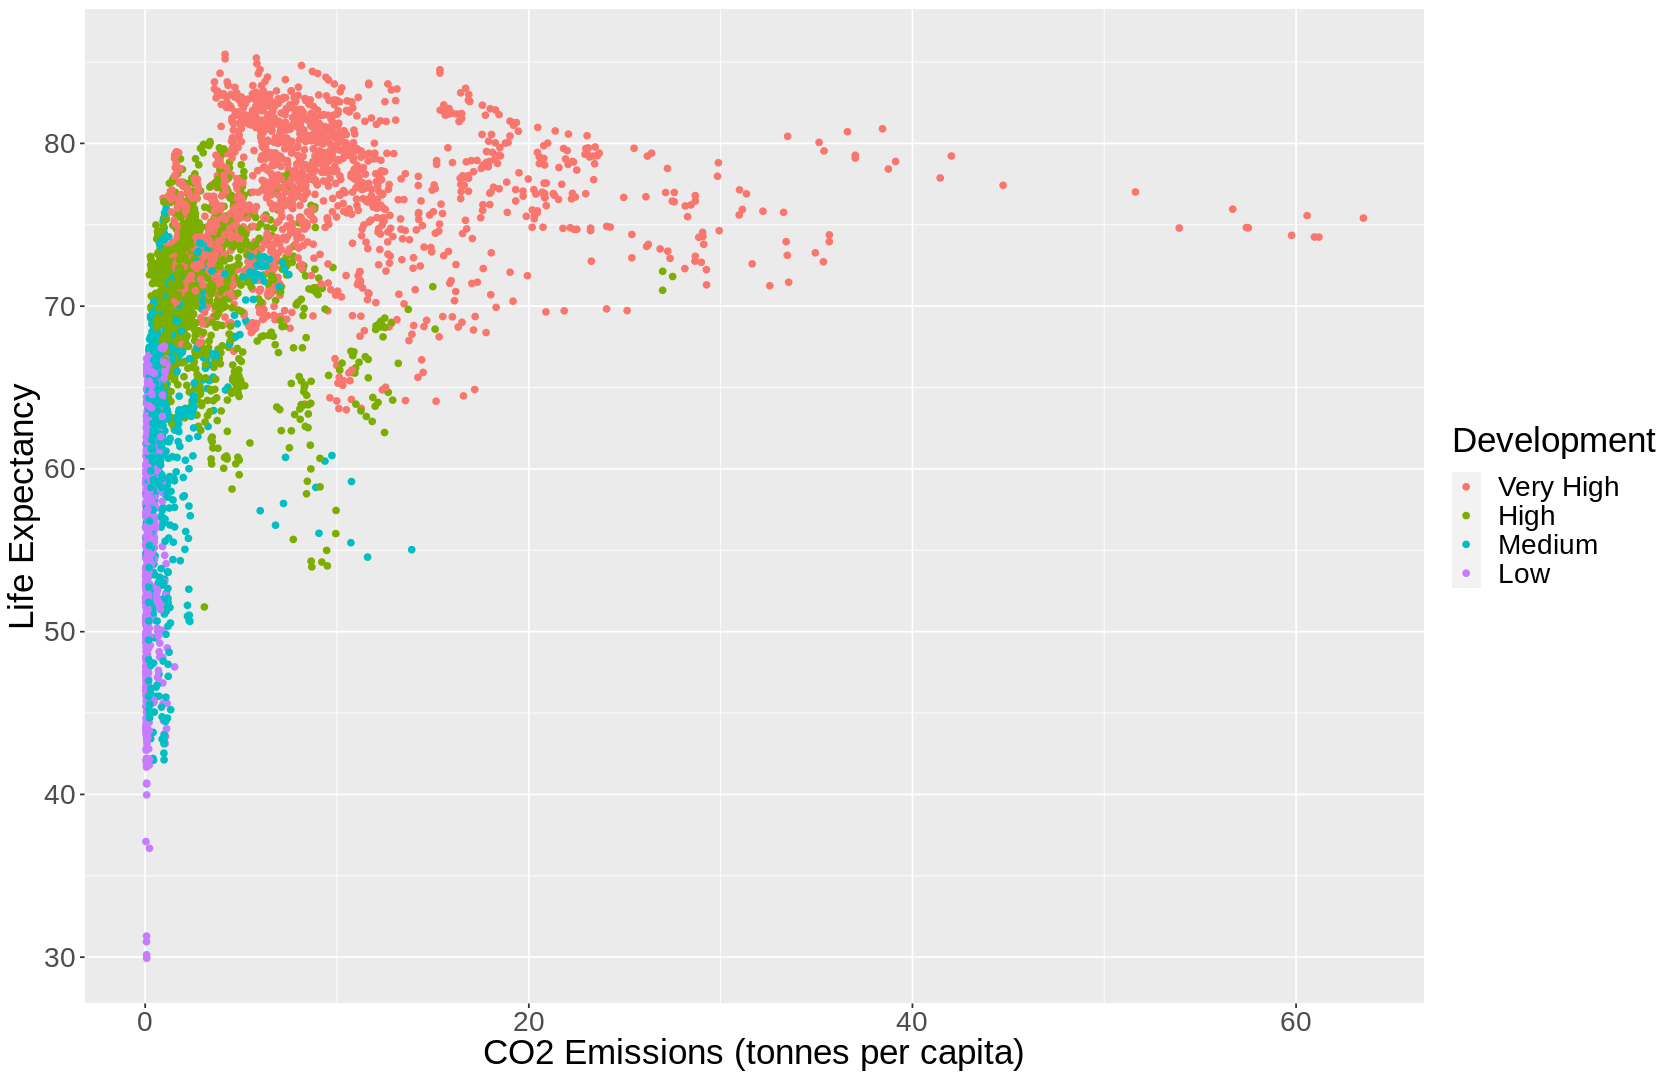

In [5]:
options(repr.plot.width = 14, repr.plot.height = 9)
gni_plot <- training_data |>
    ggplot(aes(x = gni_per_capita, y = life_expectancy, colour = development)) +
    geom_point() +
    labs(x = "GNI (per capita)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 21))
poverty_plot <- training_data |>
    ggplot(aes(x = poverty_rate, y = life_expectancy, colour = development)) +
    geom_point() +
    labs(x = "Poverty Rate (% of population)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 21))
schooling_plot <- training_data |>
    ggplot(aes(x = mean_schooling, y = life_expectancy, colour = development)) +
    geom_point() +
    labs(x = "Mean Schooling (years)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 21))
co2_plot <- training_data |>
    ggplot(aes(x = co2_per_capita, y = life_expectancy, colour = development)) +
    geom_point() +
    labs(x = "CO2 Emissions (tonnes per capita)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 21))

gni_plot
poverty_plot
schooling_plot
co2_plot